# Testing with a dataset 

We compare different model on the dataset of wikiann that contains tags `['PER', 'ORG', 'LOC']`
We get teh score by comparing the output at the entity level and not at the token level.

In [1]:
import pickle
from collections import defaultdict
from ner.process_results import get_metrics, get_metrics_all, show_cm, show_cm_multi, get_metrics_all_extended, show_cm_multi_extended
# from ner.ner_models import get_results
from ner.Datasets.Conll2003Dataset import load_conll_dataset
from ner.utils import Utils

import os
import pandas as pd

%load_ext autoreload
%autoreload 2

language  = 'en'
utils = Utils(language)

dataset_train, dataset_llama = load_conll_dataset()

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
import pickle

folder_path = './ner/saves/results/'

results_files = sorted([f for f in os.listdir(folder_path) if '2000' in f and 'quantization' in f and '2000' in f])
 
results_llama = {}
for file_name in results_files:
    file_path = folder_path + file_name
    with open(file_path, 'rb') as f:
        loaded = pickle.load(f)
        if isinstance(loaded, dict) :
            results_llama[file_name] = loaded
        else :
            results_llama[file_name] = {}
            results_llama[file_name]['basic'] = loaded
    results_llama[file_name]['true_labels'] = dataset_llama['spans']
    cm = {}
    f1 = {}
    precision = {}
    recall = {}
    y_true, y_pred, all_nes= {},{}, {}
    for model in results_llama[file_name] : 
        if model != "true_labels" :
            cm[model],f1[model], precision[model], recall[model], y_true[model], y_pred[model], all_nes[model]= get_metrics_all(results_llama[file_name][model], results_llama[file_name]['true_labels'])
            # show_cm_multi(cm[model],f1[model], precision[model], recall[model], model)
    print(f"{file_name} { f1}")


results_pred_labels_colnn2003_llama-13b-ft_quantization_2000_50_2762_False_5_discussion.pkl {'Q2_K': 0.8073394495412844, 'Q4_0': 0.8952380952380953, 'Q5_0': 0.8952380952380953, 'Q8_0': 0.9038461538461539}


In [24]:
folder_path = './ner/saves/results/'

results_files = [f for f in os.listdir(folder_path) if f.startswith('results_pred_labels_colnn2003_mistralai')]
results_files

['results_pred_labels_colnn2003_mistralai_50_0_True_0.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_2762_False_5.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_2762_False_5_@@##.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_690_True_5_@@##.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_2762_False_16_discussion.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_2762_False_32_@@##.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_690_False_5_@@##.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_2762_False_5_discussion.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_2762_False_32.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_2762_True_5_@@##.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_2762_False_16_@@##.pkl',
 'results_pred_labels_colnn2003_mistralai_50_0_False_0.pkl',
 'results_pred_labels_colnn2003_mistralai_0_50_2762_False_16.pkl']

dict_keys(['models'])


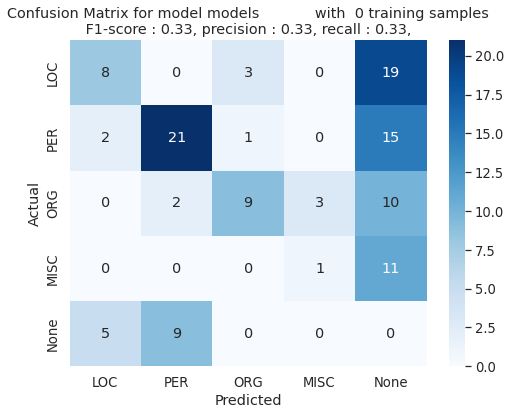

results_pred_labels_colnn2003_mistralai_0_50_2762_False_16_@@##.pkl {'models': 0.3277310924369748}


In [44]:
file_name = results_files[10]
file_path = folder_path + file_name
with open(file_path, 'rb') as f:
    results_llama[file_name]= pickle.load(f) 
print(results_llama[file_name].keys()) 
results_llama[file_name]['true_labels'] = dataset_llama['spans']
cm = {}
f1 = {}
precision = {}
recall = {}
y_true, y_pred, all_nes= {},{}, {}
for model in results_llama[file_name] : 
    if model != "true_labels" :
        cm[model],f1[model], precision[model], recall[model], y_true[model], y_pred[model], all_nes[model]= get_metrics_all(results_llama[file_name][model], results_llama[file_name]['true_labels'])
        show_cm_multi(cm[model],f1[model], precision[model], recall[model], model)
print(f"{file_name} {f1}")

In [22]:
f1s

NameError: name 'f1s' is not defined

In [107]:
from ner.Llama2_NER import Llama2_NER_FewShots_Entity
few_shots_ner = Llama2_NER_FewShots_Entity(dataset_train, "", Utils())

few_shots_ner.get_prompts("Washington is the capital of the Unisted States", tags = ["PER", "ORG", "LOC"])

[nltk_data] Downloading package stopwords to /home/ketl2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


: 

In [41]:
from ner.Llama2_NER import Llama2_NER_FewShots_Random
import pickle
llama = Llama2_NER_FewShots_Random("","","")
tags = ["PER", "LOC", "ORG", "MISC"]
results = {}
for model in ['7b', '13b']:
    for nb_samp in [500,1000,1500]:
        with open(f"./ner/saves/results/results_pred_labels_colnn2003_ft_{model}_{nb_samp}_50.pkl", 'rb') as f :
            mod = f"{model}_{nb_samp}"
            results[mod] = pickle.load(f)
results['true_labels'] = dataset_llama['spans']


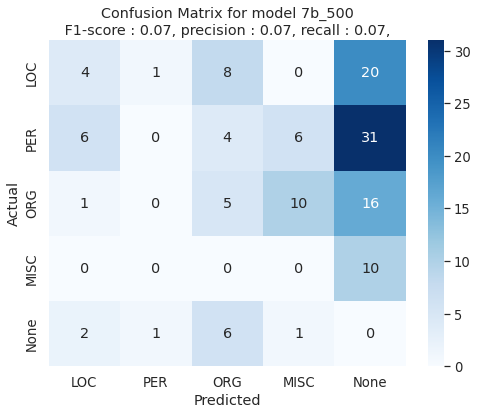

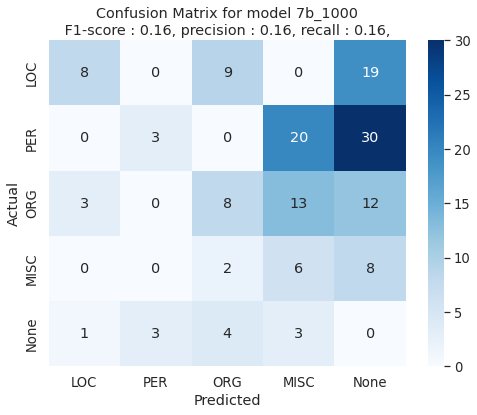

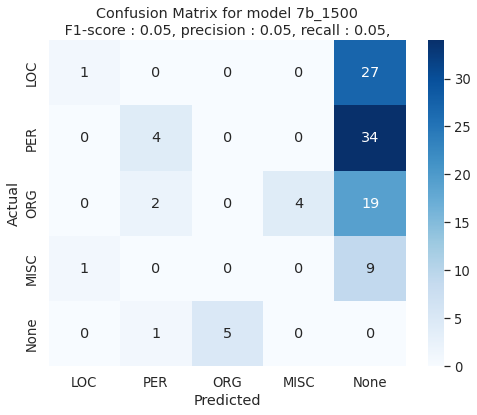

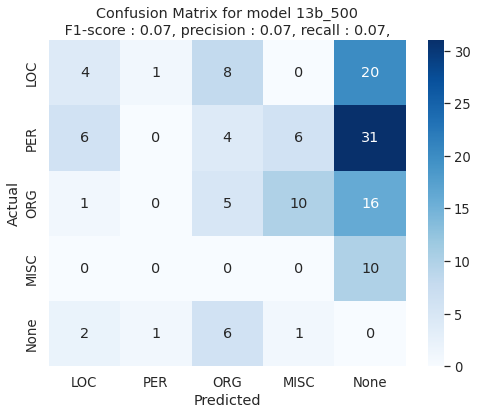

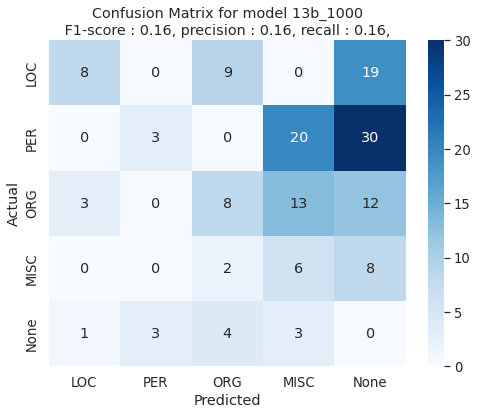

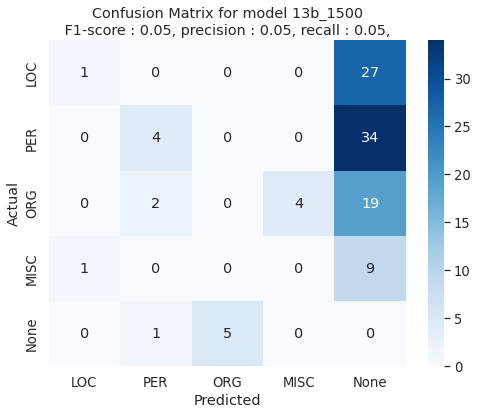

In [42]:

cm = {}
f1 = {}
precision = {}
recall = {}
y_true, y_pred, all_nes= {},{}, {}
res = results
for model in res: 
    if model != "true_labels" :
        cm[model],f1[model], precision[model], recall[model], y_true[model], y_pred[model], all_nes[model]= get_metrics_all(res[model], res['true_labels'])
        # show_cm(cm[model], [{tag : f"{f1s[model][tag]:.2f}" } for tag in ["general"] + tag_type], model)
        show_cm_multi(cm[model],f1[model], precision[model], recall[model], model)


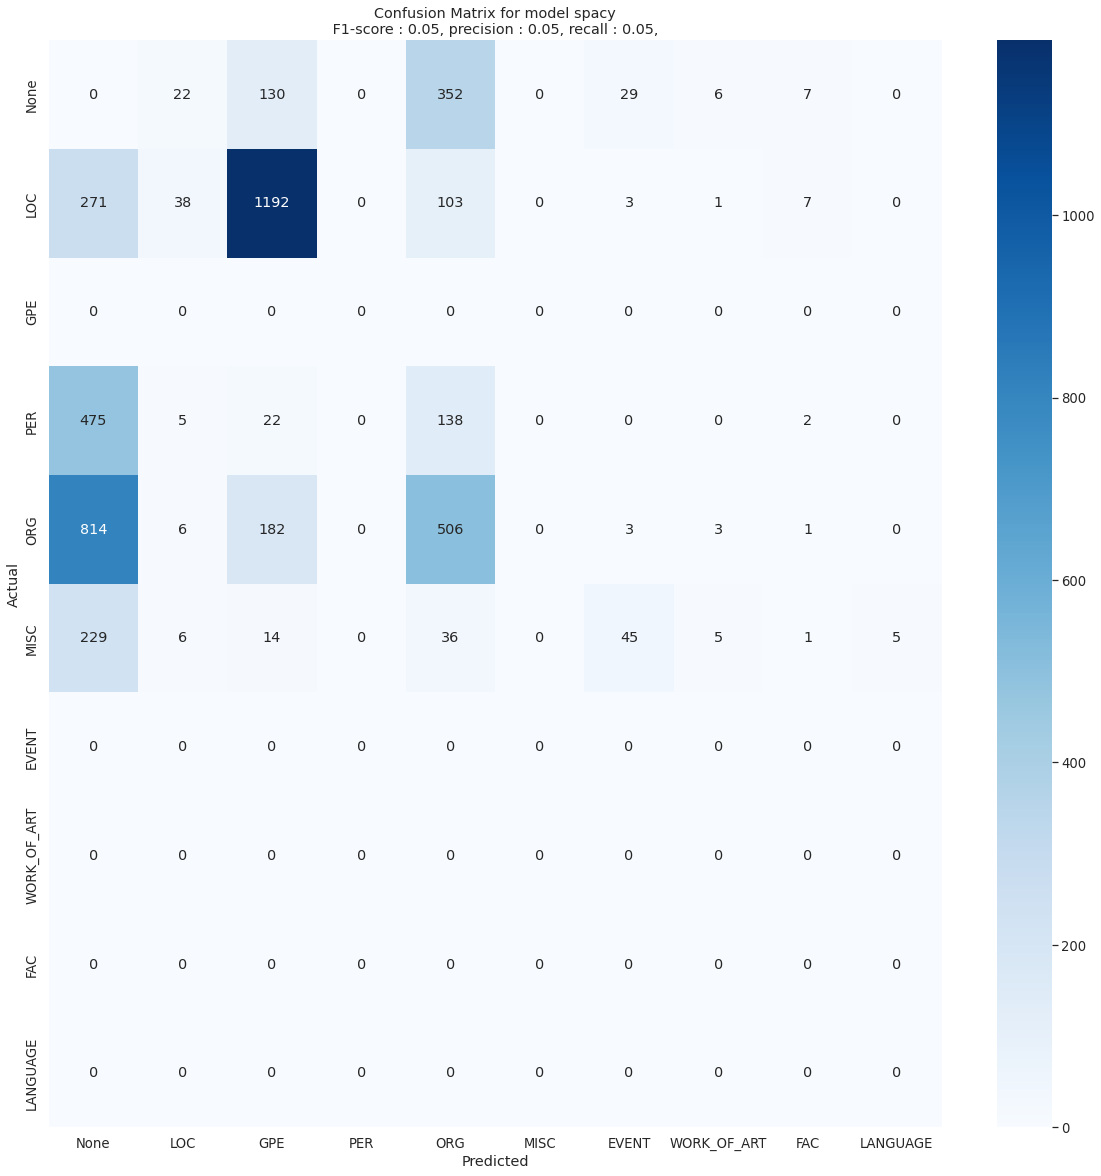

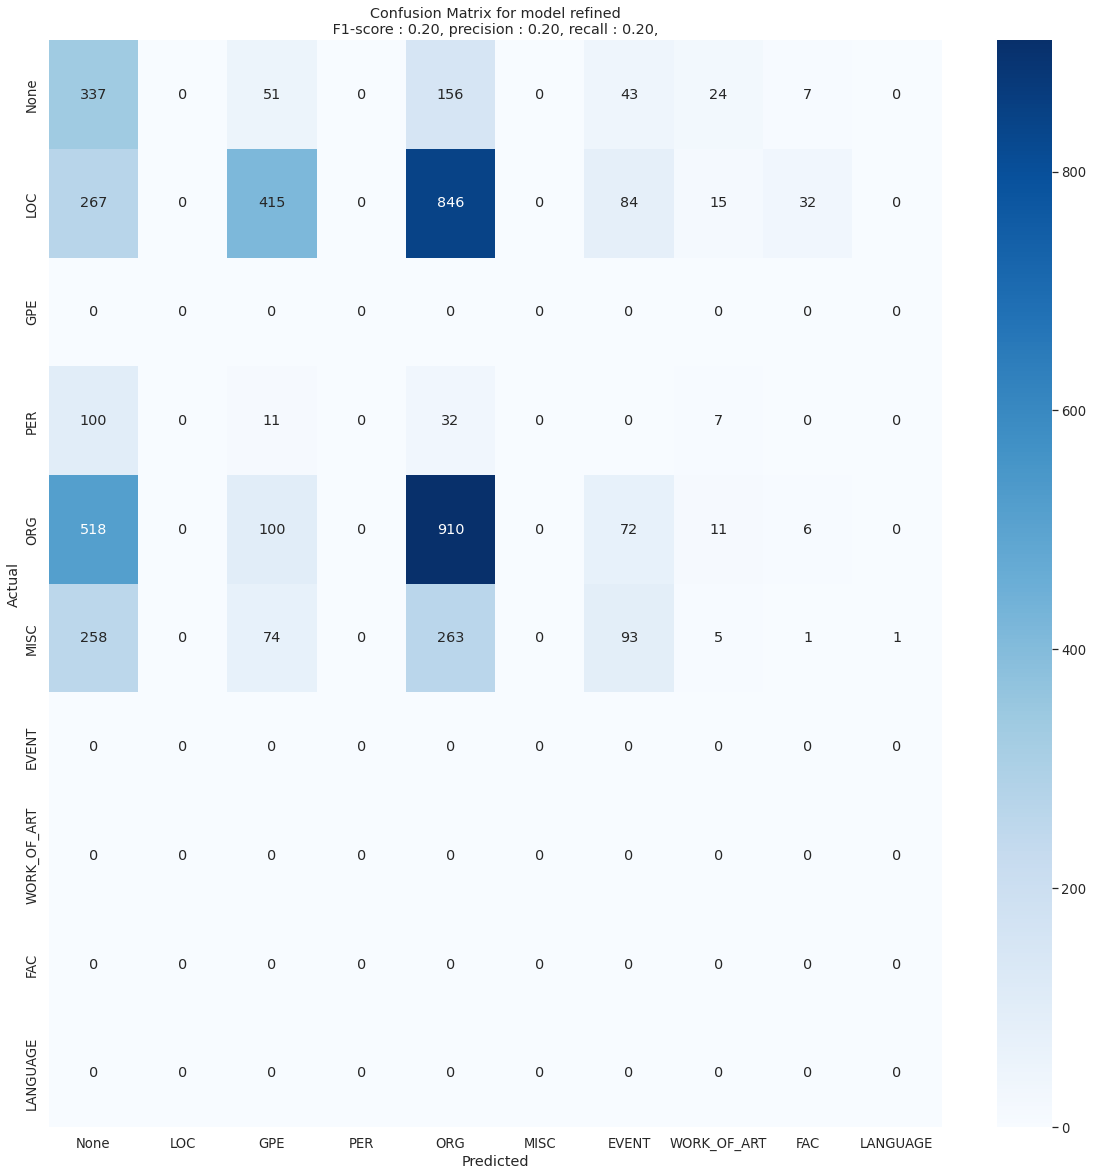

In [12]:
cm = {}
f1 = {}
precision = {}
recall = {}
y_true, y_pred, all_nes= {},{}, {}
res = results
for model in res : 
    if model in ['spacy', 'refined'] :
        cm[model],f1[model], precision[model], recall[model], y_true[model], y_pred[model], all_nes[model]= get_metrics_all_extended(res[model], res['true_labels'])
        # show_cm(cm[model], [{tag : f"{f1s[model][tag]:.2f}" } for tag in ["general"] + tag_type], model)
        show_cm_multi_extended(cm[model],f1[model], precision[model], recall[model], model)

In [3]:
import pandas as pd 
key ="entity"
resu = pd.DataFrame({"gold" : y_true[key], "pred" : y_pred[key], 'named_entity' : all_nes[key]})
resu[resu['gold'] != resu['pred']]

KeyError: 'entity'

In [343]:
dfs = {}
for key in results :
    flattened = [item for sublist in results[key] for item in sublist]
    dfs[key] = pd.DataFrame([{'entity' : ne[0], 'tag' : ne[1], 'ref_tag' : ne[2] if len(ne)>2 else ""} for ne in flattened])
    dfs[key] = dfs[key].groupby('entity').agg(set)
dfs['true_labels'].rename(columns={'tag': 'gold_tags'}, inplace=True)
del dfs['true_labels']['ref_tag']

for key in results :
    if key != "true_labels" :
        dfs[key] = dfs['true_labels'].merge(dfs[key], on='entity', how='outer')
        dfs[key].fillna(-1, inplace=True)


for key in results_llama :
    flattened = [item for sublist in results_llama[key] for item in sublist]
    dfs[key] = pd.DataFrame([{'entity' : ne, 'tag' : tag} for ne, tag in flattened])
    dfs[key] = dfs[key].groupby('entity').agg(set)
dfs['true_labels'].rename(columns={'tag': 'gold_tags'}, inplace=True)
for key in results_llama :
    if key != "true_labels" :
        dfs[key] = dfs['true_labels'].merge(dfs[key], on='entity', how='outer')
        dfs[key].fillna(-1, inplace=True)

In [259]:
key = 'few_shots_random'
tag_distr_missed_by_model(key), tag_distr_added_by_model(key)

(gold_tags
 {PER}     20
 {ORG}     13
 {LOC}     12
 {MISC}    11
 Name: count, dtype: int64,
 tag
 {LOC}              7
 {PER}              3
 {ORG}              3
 {PER, ORG, LOC}    1
 Name: count, dtype: int64)

In [262]:
key = 'few_shots_sentence'
tag_distr_missed_by_model(key), tag_distr_added_by_model(key)

(gold_tags
 {LOC}     10
 {PER}      9
 {MISC}     7
 {ORG}      5
 Name: count, dtype: int64,
 tag
 {MISC}             5
 {LOC}              5
 {PER}              3
 {PER, ORG, LOC}    1
 {ORG}              1
 Name: count, dtype: int64)

In [265]:
key = 'entity'
tag_distr_missed_by_model(key), tag_distr_added_by_model(key)

(gold_tags
 {PER}     13
 {ORG}      9
 {LOC}      9
 {MISC}     8
 Name: count, dtype: int64,
 tag
 {MISC}         5
 {ORG}          4
 {LOC}          4
 {PER}          3
 {MISC, PER}    1
 Name: count, dtype: int64)

In [294]:
key = 'refined'
tag_distr_missed_by_model(key), tag_distr_added_by_model(key)
# temp = dfs[key][dfs[key]['gold_tags'] != -1]
# temp[temp['tag'] == {'MISC'}][['gold_tags','tag_precision_y']]['tag_precision_y'].value_counts()

(gold_tags
 {MISC}    2
 {LOC}     1
 Name: count, dtype: int64,
 ref_tag
 {PERSON}                           1001
 {ORG}                               617
 {None}                              530
 {GPE}                               221
 {ORG, None}                         115
 {EVENT}                              95
 {GPE, ORG}                           70
 {WORK_OF_ART}                        35
 {GPE, ORG, None}                     25
 {FAC}                                24
 {PERSON, None}                       22
 {GPE, None}                          20
 {ORG, PERSON}                        18
 {EVENT, None}                        18
 {EVENT, ORG}                          8
 {EVENT, ORG, None}                    7
 {EVENT, GPE, ORG, None}               5
 {None, FAC}                           3
 {WORK_OF_ART, None}                   3
 {PERSON, ORG, None}                   3
 {WORK_OF_ART, PERSON}                 3
 {ORG, FAC}                            3
 {EVENT, GPE, ORG}      

In [293]:
key = 'few_shots_random'
# dfs[key]['diff_tag'] = dfs[key]['gold_tags'] - dfs[key]['tag']
def tag_distr_missed_by_model(key):
    return dfs[key][dfs[key]['tag'] == -1]['gold_tags'].value_counts()

def tag_distr_added_by_model(key):
    return dfs[key][dfs[key]['gold_tags'] == -1]['tag'].value_counts()

In [345]:
key = 'refined'
dfs[key][dfs[key]['ref_tag'] == {None}]['gold_tags'].value_counts()

Series([], Name: count, dtype: int64)

In [346]:
key = 'spacy'
dfs[key][dfs[key]['ref_tag'] == {None}]['gold_tags'].value_counts()

Series([], Name: count, dtype: int64)

In [347]:
dfs[key]

,gold_tags,tag,ref_tag
entity,,,
1. FC Cologne,{ORG},-1,-1
1860 Munich,{ORG},-1,-1
1966 World Cup,{MISC},-1,-1
1993 World Cup,{MISC},-1,-1
1995 World Cup,{MISC},-1,-1
...,...,...,...
weekly,-1,{MISC},{DATE}
year,-1,{MISC},{DATE}
year-on-year,-1,{MISC},{DATE}


In [20]:
dataset_llama[10]['text'], dataset_llama[11]['spans']

('LONDON 1996-12-07',
 [['Internet', 'MISC'],
  ['Marc Pearl', 'PER'],
  ['Information Technology Association of America', 'ORG'],
  ['U.S.', 'LOC']])